In [ ]:
# STEP 1: Upload file (must be its own cell)
import platform, torch
from google.colab import files

print("Python", platform.python_version(), "| CUDA?", torch.cuda.is_available())
up = files.upload()               # choose your file here
assert up, "No file uploaded."
FNAME = next(iter(up))
print("FNAME =", FNAME)

Python 3.12.12 | CUDA? True


Saving Screenshot_20251020_195004_Chrome.jpg to Screenshot_20251020_195004_Chrome (1).jpg
FNAME = Screenshot_20251020_195004_Chrome (1).jpg


In [ ]:
# ONE-CELL: pick latest uploaded image automatically → run DeepSeek-OCR
%pip -q install "transformers==4.46.3" "tokenizers==0.20.3" einops addict easydict pillow

import os, glob, time, torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

assert torch.cuda.is_available(), "GPU is OFF. Runtime → Change runtime type → GPU, then rerun."

# 1) Find most recent image in /content if FNAME is missing
def pick_latest_image():
    pats = ["/content/*.png", "/content/*.jpg", "/content/*.jpeg", "/content/*.webp"]
    files = []
    for p in pats:
        files += glob.glob(p)
    assert files, "No image file found in /content. If you just uploaded, it’s saved in /content; try again."
    files.sort(key=lambda f: os.path.getmtime(f), reverse=True)
    return files[0]

img_path = None
try:
    # use FNAME if it exists and points to a file
    if "FNAME" in globals() and isinstance(FNAME, str) and os.path.isfile(FNAME):
        img_path = FNAME
except Exception:
    pass
if not img_path:
    img_path = pick_latest_image()

print("Using image:", img_path)

# 2) Optional: shrink giant screenshots for speed
img = Image.open(img_path).convert("RGB")
if max(img.size) > 2000:
    s = 2000 / max(img.size)
    img = img.resize((int(img.width*s), int(img.height*s)))
    img_path_proc = "/content/_shrunk.png"
    img.save(img_path_proc, optimize=True)
else:
    img_path_proc = img_path

# 3) Load model (needs eager attention)
model_id = "deepseek-ai/DeepSeek-OCR"
tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
if tok.pad_token is None and tok.eos_token is not None:
    tok.pad_token = tok.eos_token

t0 = time.time()
model = AutoModel.from_pretrained(
    model_id,
    trust_remote_code=True,
    use_safetensors=True,
    attn_implementation="eager"   # required for this arch
).to(dtype=torch.bfloat16, device="cuda").eval()
print(f"Model loaded in {time.time()-t0:.1f}s")

# 4) Fast OCR for screenshots (no tiling)
prompt = "<image>\nFree OCR."
outdir = "/content/out"; os.makedirs(outdir, exist_ok=True)

@torch.inference_mode()
def run_ocr(path):
    t = time.time()
    res = model.infer(
        tok,
        prompt=prompt,
        image_file=path,
        output_path=outdir,
        base_size=768,       # smaller canvas = faster
        image_size=512,      # smaller tiles
        crop_mode=False,     # screenshots usually don't need tiling
        save_results=True,
        test_compress=False
    )
    print(f"[OK] {os.path.basename(path)} in {time.time()-t:.1f}s")
    return res

out = run_ocr(img_path_proc)
print("Saved files in:", outdir)
print(out)

Using image: Screenshot_20251020_195004_Chrome (1).jpg


You are using a model of type deepseek_vl_v2 to instantiate a model of type DeepseekOCR. This is not supported for all configurations of models and can yield errors.
Some weights of DeepseekOCRForCausalLM were not initialized from the model checkpoint at deepseek-ai/DeepSeek-OCR and are newly initialized: ['model.vision_model.embeddings.position_ids']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Model loaded in 9.4s
directly resize
BASE:  torch.Size([1, 64, 1280])
NO PATCHES
def pdf_to_images(pdf_path):
    pdf = pdflib.PdfDocument(pdf_path)
    for i in range(len(pdf)):
    page = pdf[i]
    p1 = page.finder('scale=2').to_pil()
    tmp = f"context=getpage_{i+1:03d}.png"
    pil.save(tmp)
    yield tmp, i

# -- route: image vs pdf -- 
ext = os.path.splitext(fname)[1].lower()
if ext in [".pdf", ".png"]:
    for img_path, idx in pdf_to_images(fname):
    run_on_image(img_path, idx)
else:
    # ensure it is a loadable image
    try:
    Image.open(fname).convert("RGB")
    except Exception as e:
    raise SystemExit(f"Not an image/PDF I can read: {e}")
    run_on_image(fname, 0)

print(f"\nDone. Markdown and outputs saved in: {outdir}")

Python 3.12.12 | Torch 2.8.0+cu126 | CUDA OK
Upload an IMAGE (.jpg/png/webp) or a PDF:
Choose File: No file chosen Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable.
=

image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]

[OK] Screenshot_20251020_195004_Chrome (1).jpg in 10.7s
Saved files in: /content/out
None


In [ ]:
# Inspect outputs, render Markdown inline, and download the file
import os, glob
from IPython.display import display, Markdown
from google.colab import files as cfiles

outdir = "/content/out"
assert os.path.isdir(outdir), "No /content/out directory found."

outs = sorted(glob.glob(f"{outdir}/*"), key=os.path.getmtime, reverse=True)
print("All output files (newest first):")
for p in outs: print(" -", os.path.basename(p))

# pick the newest markdown-like file
md = [p for p in outs if p.lower().endswith((".md", ".markdown", ".txt"))]
assert md, "No .md/.txt output found. Check the listed files above."
md_path = md[0]
print("\nRendering:", os.path.basename(md_path))
with open(md_path, "r", encoding="utf-8", errors="ignore") as f:
    text = f.read()

display(Markdown(text))        # show in notebook
cfiles.download(md_path)       # trigger download to your device

All output files (newest first):
 - result_with_boxes.jpg
 - result.mmd
 - images


AssertionError: No .md/.txt output found. Check the listed files above.

In [ ]:
# View + convert DeepSeek-OCR .mmd → .md, and download
import os, glob, shutil
from IPython.display import Markdown, display
from google.colab import files as cfiles

outdir = "/content/out"
mmds = sorted(glob.glob(f"{outdir}/*.mmd"), key=os.path.getmtime, reverse=True)
assert mmds, "No .mmd file found in /content/out."
mmd_path = mmds[0]
md_path  = os.path.splitext(mmd_path)[0] + ".md"

# Copy/normalize to .md (also make a .txt for good measure)
with open(mmd_path, "r", encoding="utf-8", errors="ignore") as f:
    text = f.read()
with open(md_path, "w", encoding="utf-8") as f:
    f.write(text)
txt_path = os.path.splitext(mmd_path)[0] + ".txt"
with open(txt_path, "w", encoding="utf-8") as f:
    f.write(text)

print("Showing:", os.path.basename(md_path))
display(Markdown(text))

print("\nDownloads:")
print(" -", os.path.basename(md_path))
print(" -", os.path.basename(txt_path))
cfiles.download(md_path)
cfiles.download(txt_path)

Showing: result.md


def pdf_to_images(pdf_path):
    pdf = pdflib.PdfDocument(pdf_path)
    for i in range(len(pdf)):
    page = pdf[i]
    p1 = page.finder('scale=2').to_pil()
    tmp = f"context=getpage_{i+1:03d}.png"
    pil.save(tmp)
    yield tmp, i

# -- route: image vs pdf -- 
ext = os.path.splitext(fname)[1].lower()
if ext in [".pdf", ".png"]:
    for img_path, idx in pdf_to_images(fname):
    run_on_image(img_path, idx)
else:
    # ensure it is a loadable image
    try:
    Image.open(fname).convert("RGB")
    except Exception as e:
    raise SystemExit(f"Not an image/PDF I can read: {e}")
    run_on_image(fname, 0)

print(f"\nDone. Markdown and outputs saved in: {outdir}")

Python 3.12.12 | Torch 2.8.0+cu126 | CUDA OK
Upload an IMAGE (.jpg/png/webp) or a PDF:
Choose File: No file chosen Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable.


Downloads:
 - result.md
 - result.txt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
with open("/content/out/result.mmd", "r", encoding="utf-8") as f:
    print(f.read())

def pdf_to_images(pdf_path):
    pdf = pdflib.PdfDocument(pdf_path)
    for i in range(len(pdf)):
    page = pdf[i]
    p1 = page.finder('scale=2').to_pil()
    tmp = f"context=getpage_{i+1:03d}.png"
    pil.save(tmp)
    yield tmp, i

# -- route: image vs pdf -- 
ext = os.path.splitext(fname)[1].lower()
if ext in [".pdf", ".png"]:
    for img_path, idx in pdf_to_images(fname):
    run_on_image(img_path, idx)
else:
    # ensure it is a loadable image
    try:
    Image.open(fname).convert("RGB")
    except Exception as e:
    raise SystemExit(f"Not an image/PDF I can read: {e}")
    run_on_image(fname, 0)

print(f"\nDone. Markdown and outputs saved in: {outdir}")

Python 3.12.12 | Torch 2.8.0+cu126 | CUDA OK
Upload an IMAGE (.jpg/png/webp) or a PDF:
Choose File: No file chosen Upload widget is only available when the cell has been executed in the current browser session. Please rerun this cell to enable.


In [ ]:
# STEP A: Upload a new image (PNG/JPG/JPEG/WEBP). Stores name in FNAME.
from google.colab import files
up = files.upload()
assert up, "No file uploaded."
FNAME = next(iter(up))
print("FNAME =", FNAME)

Saving Screenshot_20251019_094859_Brave.jpg to Screenshot_20251019_094859_Brave.jpg
FNAME = Screenshot_20251019_094859_Brave.jpg


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Reusing model already in memory.
directly resize
BASE:  torch.Size([1, 64, 1280])
NO PATCHES
Professor John Ioannidis of Stanford, the world’s most cited medical researcher, delivered a devastating conclusion in 2017: 20–50% of all U.S. healthcare activity is wasteful, harmful, or brings no benefit to the patient.

This isn’t a minor inefficiency; it’s a systemic collapse. The reason, as detailed by cardiologist Dr. Aseem Malhotra, is a medical misinformation mess fueled by:

- Unreliable Research: Most published studies are not fit for guiding patient care.
- Undetected Commercial Capture: Medical knowledge is under commercial control, yet most doctors are unaware.
- A Critical Skills Gap: Clinicians lack the training to appraise evidence reliability.
- Misinformed Patients: The public is flooded with inaccuracies, sabotaging their health decisions.

But the research said is a betrayal of trust.

While pharma has a legal duty to shareholders, not patients, the true failure lies with t

image: 0it [00:00, ?it/s]
other: 0it [00:00, ?it/s]


--- OCR TEXT (Markdown) ---


Professor John Ioannidis of Stanford, the world’s most cited medical researcher, delivered a devastating conclusion in 2017: 20–50% of all U.S. healthcare activity is wasteful, harmful, or brings no benefit to the patient.

This isn’t a minor inefficiency; it’s a systemic collapse. The reason, as detailed by cardiologist Dr. Aseem Malhotra, is a medical misinformation mess fueled by:

- Unreliable Research: Most published studies are not fit for guiding patient care.
- Undetected Commercial Capture: Medical knowledge is under commercial control, yet most doctors are unaware.
- A Critical Skills Gap: Clinicians lack the training to appraise evidence reliability.
- Misinformed Patients: The public is flooded with inaccuracies, sabotaging their health decisions.

But the research said is a betrayal of trust.

While pharma has a legal duty to shareholders, not patients, the true failure lies with the guardians of public health. Doctors, academic institutions, journals, and regulators are colluding with industry for financial gain.

In 2018, Dr. Malhotra warned the European Parliament that the situation had become so corrupt that “honest doctors can no longer practice honest medicine.”

This was the state of medicine before the pandemic.

The system is broken. It’s time for a reckoning.


--- Detected regions overlay ---


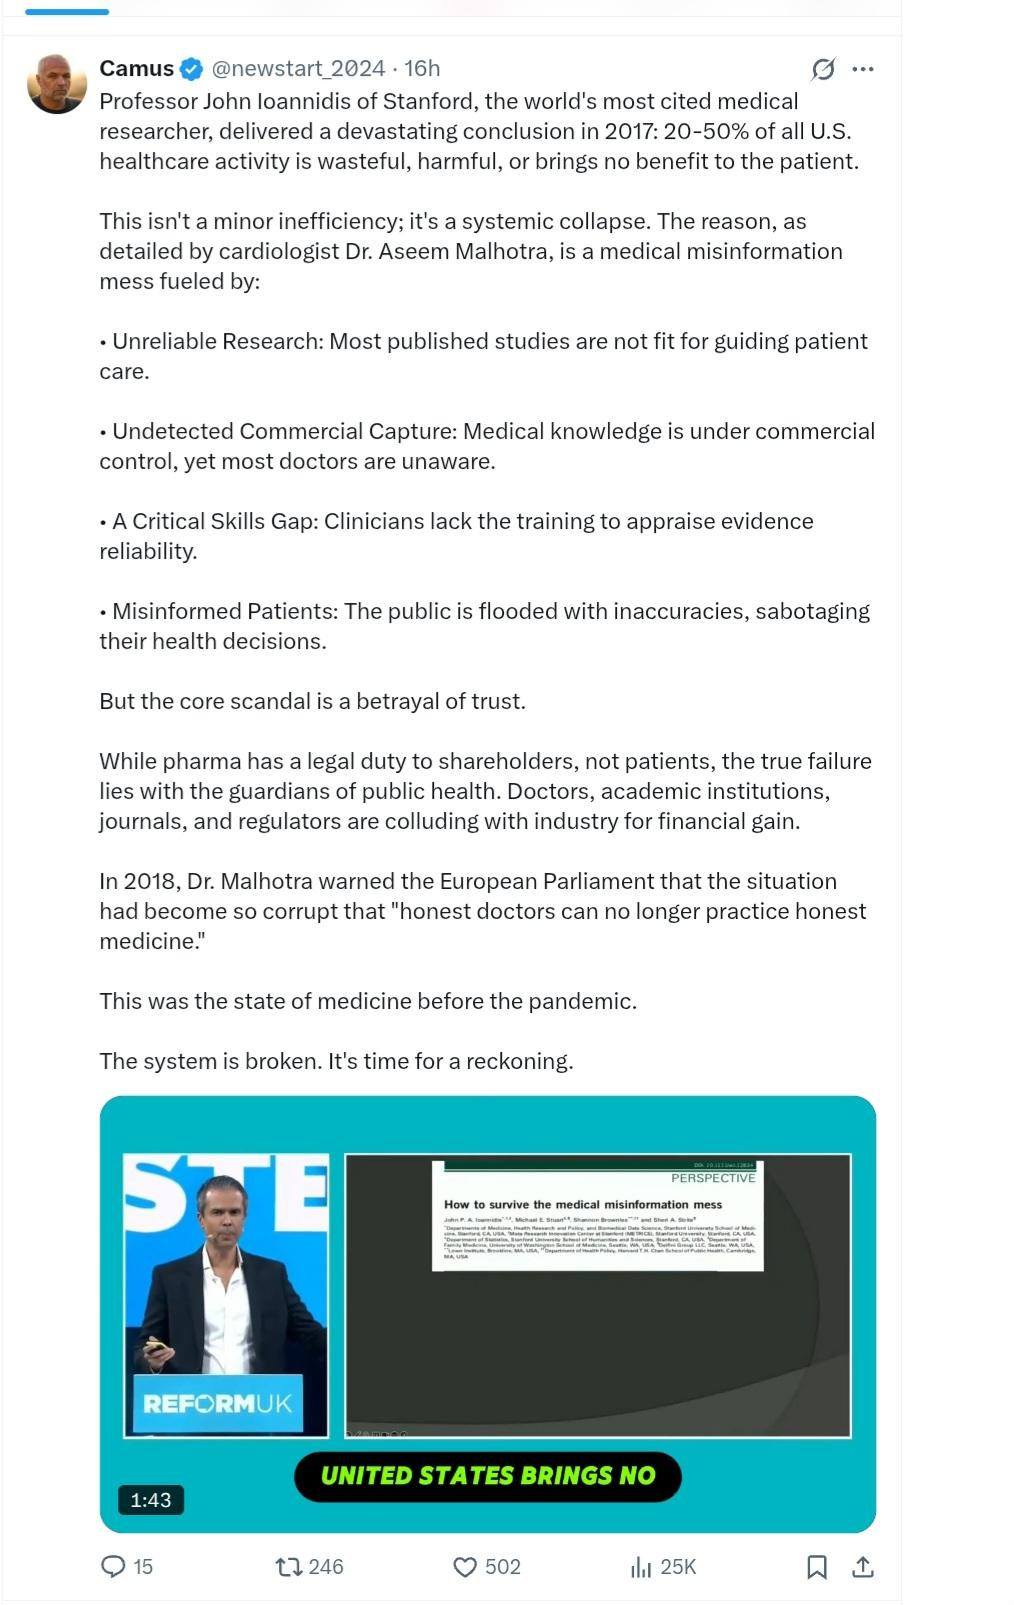


Output folder: /content/out/run_1761006107


In [ ]:
# STEP B: Run DeepSeek-OCR on FNAME and show results inline (no downloads)
%pip -q install "transformers==4.46.3" "tokenizers==0.20.3" einops addict easydict pillow

import os, time, glob, torch
from PIL import Image
from IPython.display import display, Markdown, Image as IPyImage
from transformers import AutoModel, AutoTokenizer

assert torch.cuda.is_available(), "GPU is OFF. Runtime → Change runtime type → GPU."

# --- load once, reuse on subsequent runs
if "tok" not in globals() or "model" not in globals():
    model_id = "deepseek-ai/DeepSeek-OCR"
    tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token
    t0 = time.time()
    model = AutoModel.from_pretrained(
        model_id,
        trust_remote_code=True,
        use_safetensors=True,
        attn_implementation="eager"  # required for this arch
    ).to(dtype=torch.bfloat16, device="cuda").eval()
    print(f"Model loaded in {time.time()-t0:.1f}s")
else:
    print("Reusing model already in memory.")

# --- prep image (optional shrink for giant screenshots)
img = Image.open(FNAME).convert("RGB")
if max(img.size) > 2000:
    s = 2000 / max(img.size)
    img = img.resize((int(img.width*s), int(img.height*s)))
    img_path = "/content/_current_shrunk.png"
    img.save(img_path, optimize=True)
else:
    img_path = FNAME

# --- unique output folder so runs don’t overwrite each other
outdir = f"/content/out/run_{int(time.time())}"
os.makedirs(outdir, exist_ok=True)

# --- OCR (fast settings for screenshots)
prompt = "<image>\nFree OCR."
with torch.inference_mode():
    _ = model.infer(
        tok,
        prompt=prompt,
        image_file=img_path,
        output_path=outdir,
        base_size=768,     # smaller canvas = faster
        image_size=512,    # smaller tiles
        crop_mode=False,   # screenshots usually don't need tiling
        save_results=True,
        test_compress=False
    )

# --- show results inline
# DeepSeek writes Markdown as .mmd
mmd = sorted(glob.glob(f"{outdir}/*.mmd"), key=os.path.getmtime, reverse=True)
if mmd:
    with open(mmd[0], "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    print("\n--- OCR TEXT (Markdown) ---")
    display(Markdown(text))
else:
    print("No .mmd produced — check overlay image for boxes/text regions.")

# Show overlay with detected boxes if present
boxes = os.path.join(outdir, "result_with_boxes.jpg")
if os.path.isfile(boxes):
    print("\n--- Detected regions overlay ---")
    display(IPyImage(filename=boxes))

print("\nOutput folder:", outdir)

In [ ]:
# STEP A: Upload complex image (PNG/JPG/JPEG/WEBP). Stores name in FNAME.
from google.colab import files
up = files.upload()
assert up, "No file uploaded."
FNAME = next(iter(up))
print("FNAME =", FNAME)

Saving Screenshot_20251018_093232_Chrome.jpg to Screenshot_20251018_093232_Chrome.jpg
FNAME = Screenshot_20251018_093232_Chrome.jpg


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


Reusing model already in memory.
BASE:  torch.Size([1, 256, 1280])
PATCHES:  torch.Size([6, 100, 1280])
<|ref|>title<|/ref|><|det|>[[170, 110, 911, 290]]<|/det|>
# MIGDE 

<|ref|>text<|/ref|><|det|>[[230, 290, 845, 391]]<|/det|>
SPECIAL ISSUE DEDICATED TO #SCIFM25
THE 2ND CONFERENCE ON FOUNDATION MODELS
AND AI AGENTS FOR SCIENCE 

<|ref|>text<|/ref|><|det|>[[66, 404, 520, 422]]<|/det|>
@UM_MICDE MICDE.UMICH.EDU | SCIFM CONFERENCES.ORG 

<|ref|>text<|/ref|><|det|>[[666, 416, 933, 476]]<|/det|>
MAY 28TH - 30TH, 2025
ANN ARBOR, MI 

<|ref|>image<|/ref|><|det|>[[120, 440, 960, 915]]<|/det|>
image size:  (1200, 1812)
valid image tokens:  769
output texts tokens (valid):  173
compression ratio:  0.22
===============save results:===============


other: 100%|██████████| 4/4 [00:00<00:00, 67108.86it/s]


--- OCR TEXT (Markdown) ---



# MIGDE 


SPECIAL ISSUE DEDICATED TO #SCIFM25
THE 2ND CONFERENCE ON FOUNDATION MODELS
AND AI AGENTS FOR SCIENCE 


@UM_MICDE MICDE.UMICH.EDU | SCIFM CONFERENCES.ORG 


MAY 28TH - 30TH, 2025
ANN ARBOR, MI 

![](images/0.jpg)



--- Detected regions overlay ---


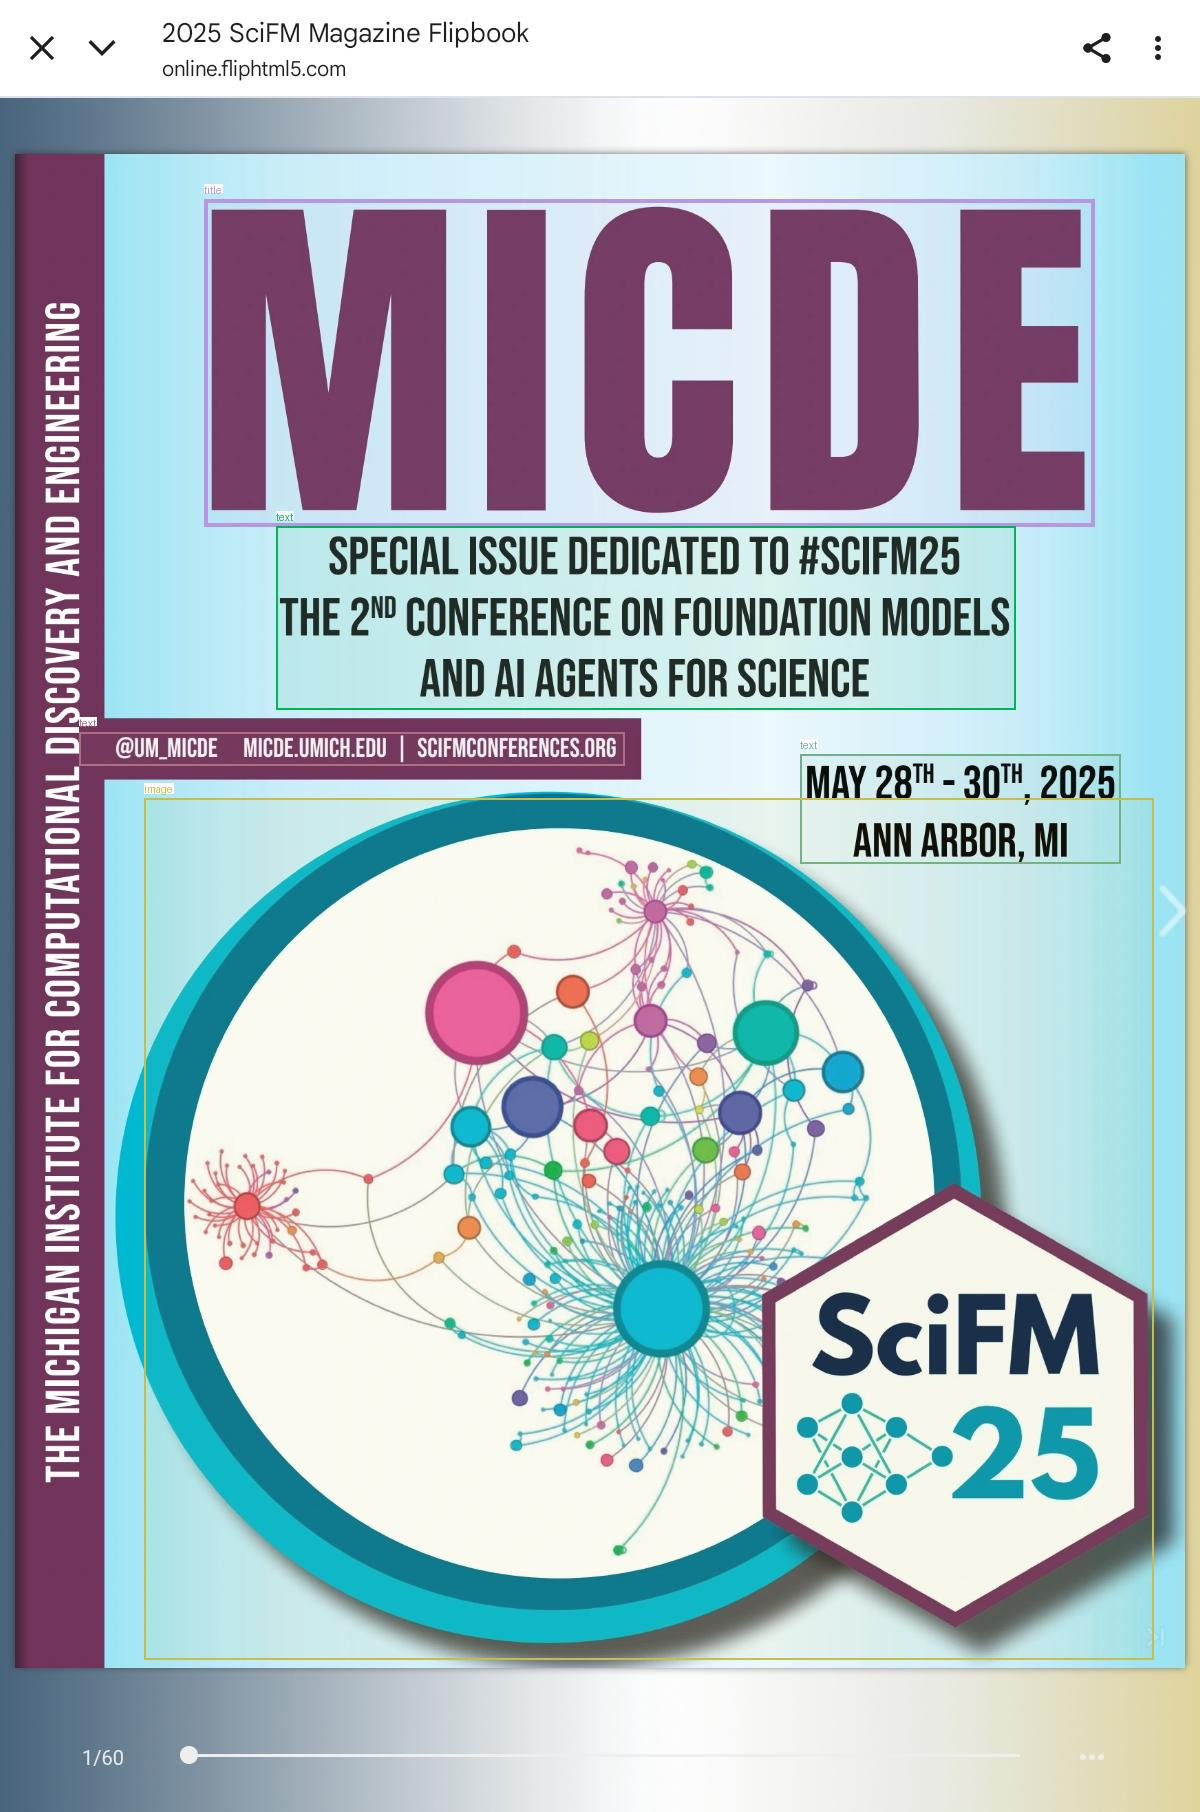


Output folder: /content/out/run_complex_1761006438


In [ ]:
# STEP C: DeepSeek-OCR complex-mode (bigger canvas + tiling), show results inline
%pip -q install "transformers==4.46.3" "tokenizers==0.20.3" einops addict easydict pillow

import os, time, glob, torch
from PIL import Image
from IPython.display import display, Markdown, Image as IPyImage
from transformers import AutoModel, AutoTokenizer

assert torch.cuda.is_available(), "GPU is OFF. Runtime → Change runtime type → GPU."

# --- load once, reuse on subsequent runs
if "tok" not in globals() or "model" not in globals():
    model_id = "deepseek-ai/DeepSeek-OCR"
    tok = AutoTokenizer.from_pretrained(model_id, trust_remote_code=True)
    if tok.pad_token is None and tok.eos_token is not None:
        tok.pad_token = tok.eos_token
    t0 = time.time()
    model = AutoModel.from_pretrained(
        model_id,
        trust_remote_code=True,
        use_safetensors=True,
        attn_implementation="eager"  # required by this model
    ).to(dtype=torch.bfloat16, device="cuda").eval()
    print(f"Model loaded in {time.time()-t0:.1f}s")
else:
    print("Reusing model already in memory.")

# --- prep image (keep more detail; only shrink if truly massive)
img = Image.open(FNAME).convert("RGB")
if max(img.size) > 4000:       # only downscale *very* large images
    s = 4000 / max(img.size)
    img = img.resize((int(img.width*s), int(img.height*s)))
    img_path = "/content/_current_shrunk_complex.png"
    img.save(img_path, optimize=True)
else:
    img_path = FNAME

# --- separate output folder per run
outdir = f"/content/out/run_complex_{int(time.time())}"
os.makedirs(outdir, exist_ok=True)

# --- complex OCR: larger canvas + tiles + compression test
#     (roughly the “Gundam-ish” multi-tiling behavior from their README)
prompt = "<image>\n<|grounding|>Convert the document to markdown."

with torch.inference_mode():
    _ = model.infer(
        tok,
        prompt=prompt,
        image_file=img_path,
        output_path=outdir,
        base_size=1024,    # bigger canvas for small text
        image_size=640,    # tile size
        crop_mode=True,    # enable tiling for dense/long pages
        save_results=True,
        test_compress=True # run an extra pass to improve text fidelity
    )

# --- show Markdown inline
mmd = sorted(glob.glob(f"{outdir}/*.mmd"), key=os.path.getmtime, reverse=True)
if mmd:
    with open(mmd[0], "r", encoding="utf-8", errors="ignore") as f:
        text = f.read()
    print("\n--- OCR TEXT (Markdown) ---")
    display(Markdown(text))
else:
    print("No .mmd produced — check overlay image for detected boxes.")

# --- show overlay (detected regions) if produced
boxes = os.path.join(outdir, "result_with_boxes.jpg")
if os.path.isfile(boxes):
    print("\n--- Detected regions overlay ---")
    display(IPyImage(filename=boxes))

print("\nOutput folder:", outdir)